In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd

In [2]:
from astropy import units as u
from astropy.stats import LombScargle
from sklearn.preprocessing import robust_scale

In [3]:
from castor import spec2sqr

In [4]:
from ipywidgets import IntProgress
from IPython.display import display

In [5]:
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["image.cmap"] = "jet"

In [6]:
head = ["ID", "PER", "HJD0" ,"VMAX" ,"VAMP" ,"TYPE" ,
        "GCVS_ID", "GCVS_TYPE",
        "IR12", "IR25", "IR60", "IR100", "J", "H", "K",
        "V_IR12", "V_J", "V_H", "V_K", "J_H", "H_K"]

In [7]:
asas = pd.read_table("ACVS.1.1", sep="\s+", skiprows=2,
                     names=head, na_values=["-", "99.99"])

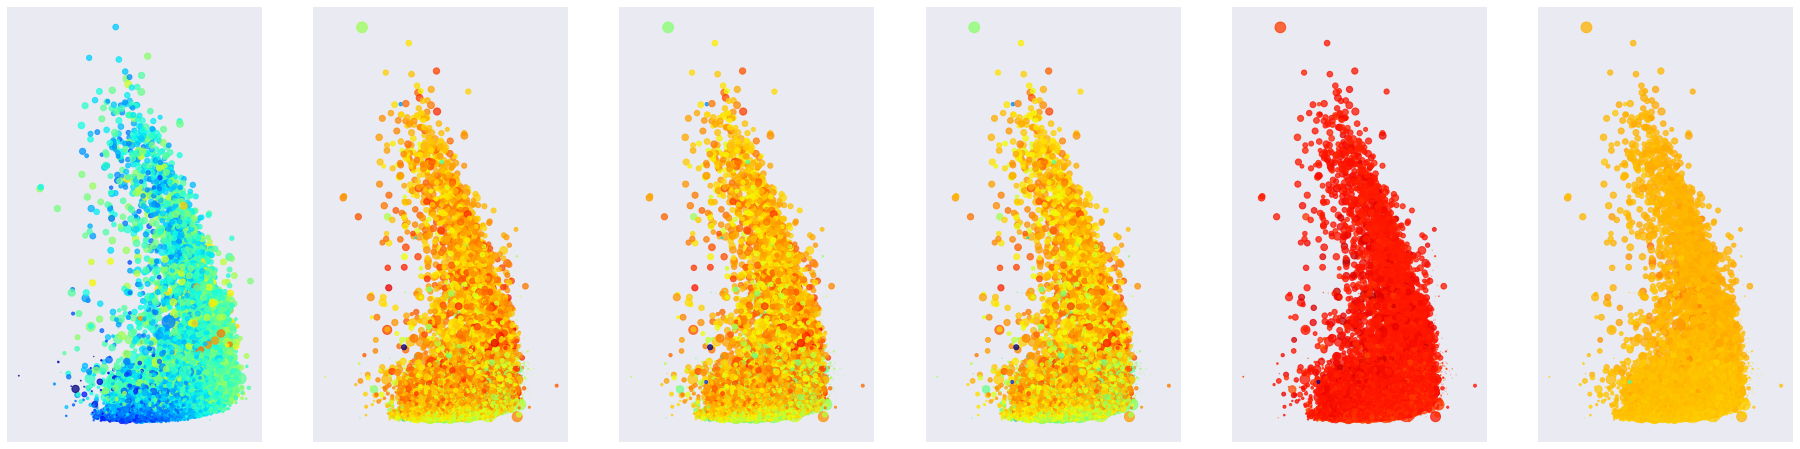

In [8]:
diff = ["V_IR12", "V_J", "V_H", "V_K", "J_H", "H_K"]
plt.figure(figsize=(32, 8))
for i in range(len(diff)):
    plt.subplot(1, 6, i+1)
    #plt.xlabel("V [mag]")
    #plt.ylabel("Amplitude")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.scatter(asas["VMAX"], asas["VAMP"],
                s=asas["PER"]/10, c=asas[diff[i]], alpha=0.75);

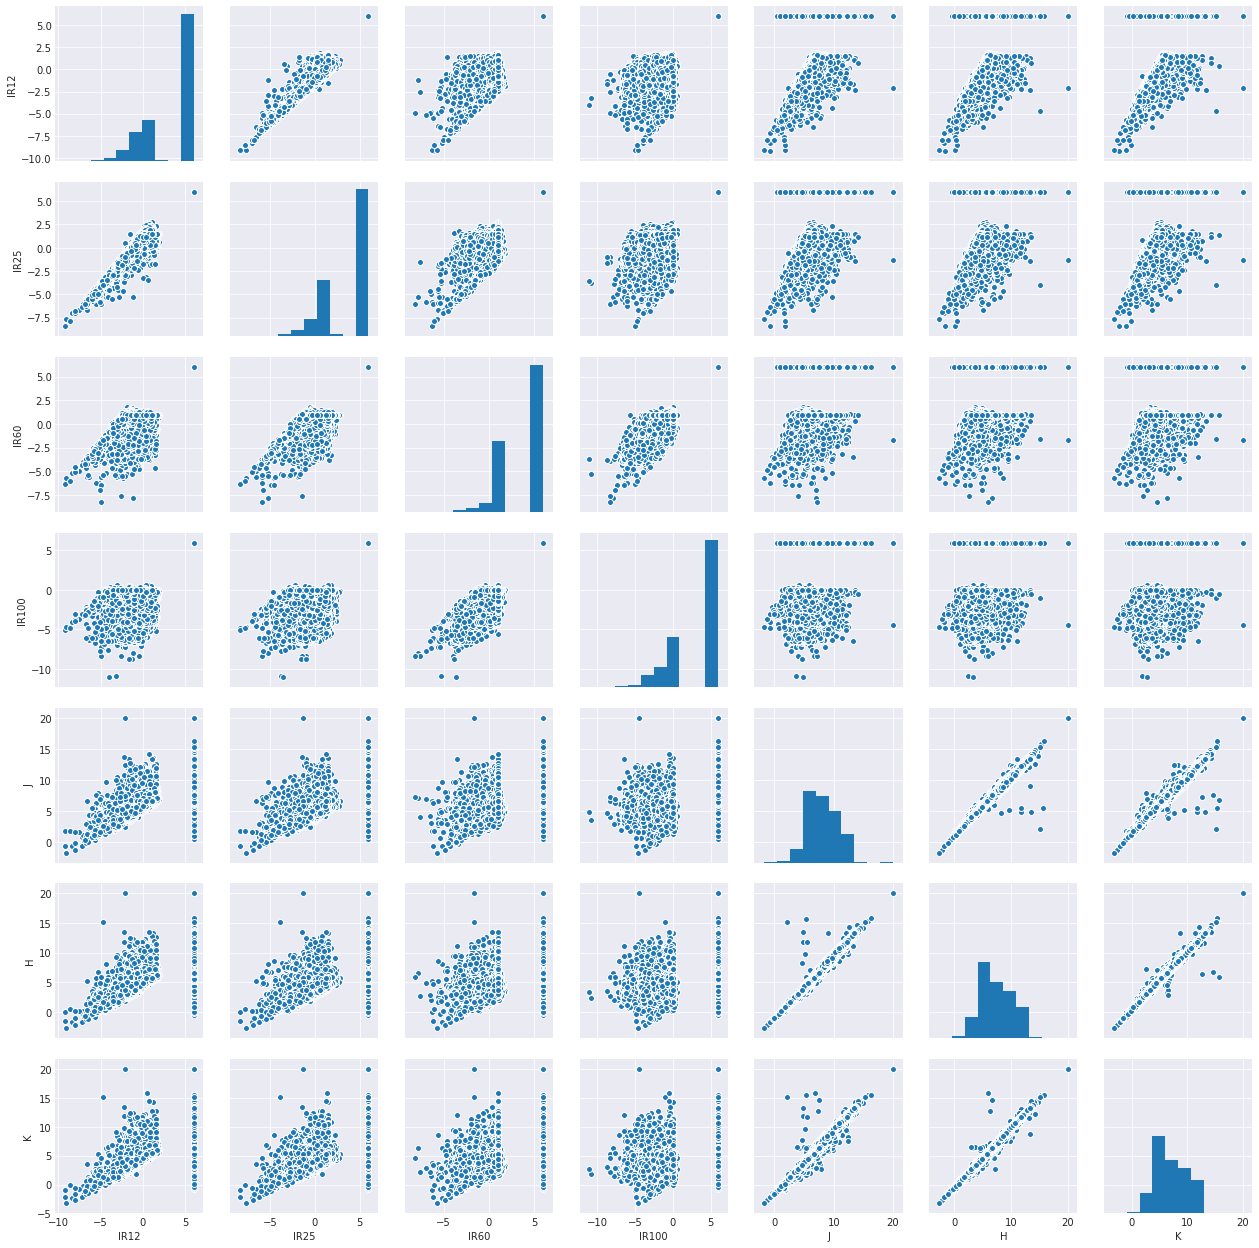

In [9]:
sns.pairplot(asas[["IR12", "IR25", "IR60", "IR100", "J", "H", "K"]]);

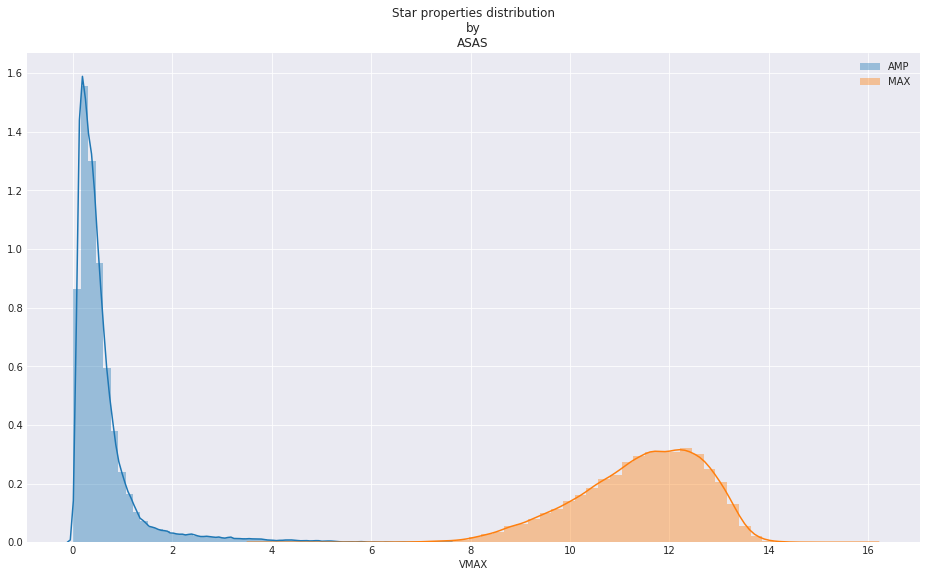

In [10]:
plt.title("Star properties distribution\nby\nASAS")
sns.distplot(asas["VAMP"], label="AMP")
sns.distplot(asas["VMAX"], label="MAX")
plt.legend();

In [11]:
names = ["HJD",
         "MAG_3", "MAG_0", "MAG_1", "MAG_2", "MAG_4",
         "MER_3", "MER_0", "MER_1", "MER_2", "MER_4",
         "GRADE", "FRAME"]

In [12]:
stars = glob.glob("/mnt/arch/ASAS/*")

In [13]:
while True:
    star = np.random.choice(stars)  # našeptávač
    data = pd.read_table(star,
                         sep="\s+",
                         na_values=[99.999],
                         names=names)
    if len(data) > 100:  # omezovač
        X = data["HJD"].values
        y = data["MAG_3"].values
        z = data["MER_3"].values
        m = data["MAG_3"].notnull()
        med = np.median(y[m])  # umíráček
        mad = np.median(np.abs(y[m]-med))
        break

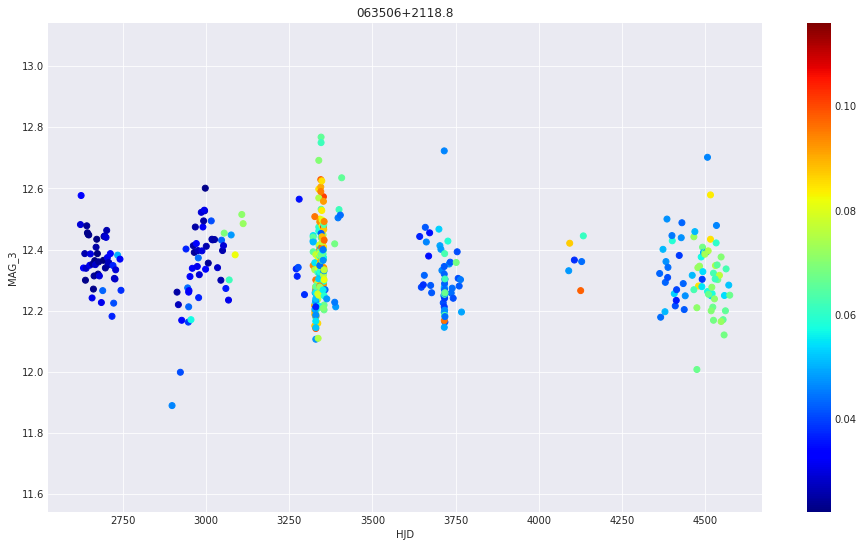

In [14]:
plt.title(os.path.basename(star))
plt.xlabel("HJD")
plt.ylabel("MAG_3")
plt.gca().invert_yaxis()
plt.ylim((med-10*mad, med+10*mad))
plt.scatter(X, y, c=z)
plt.colorbar();

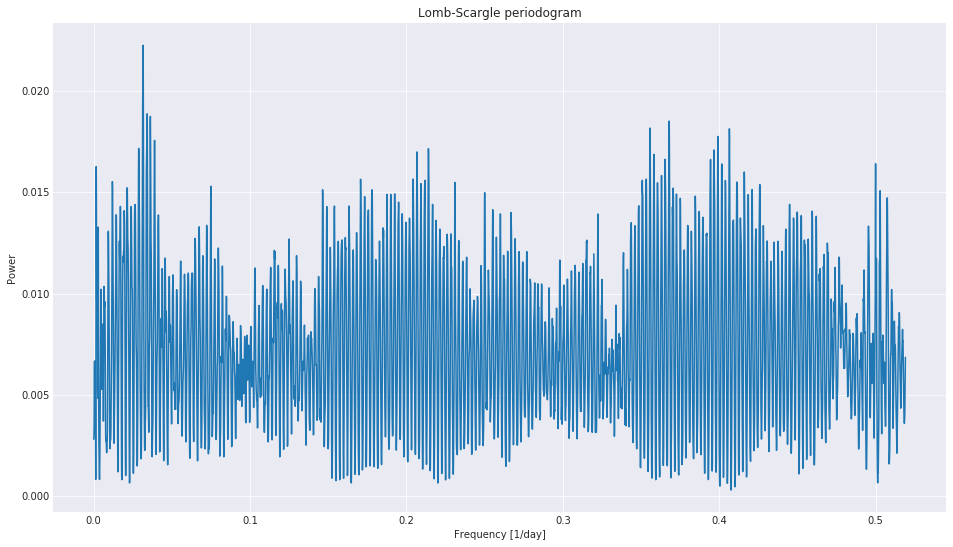

In [15]:
frequency, power = LombScargle(t=X[m]*u.day,
                               y=robust_scale(y[m].reshape(-1,1))
                                .reshape(len(X[m]),)*u.mag,
                              dy=z[m]*u.mag
                   ).autopower()
plt.title("Lomb-Scargle periodogram")
plt.xlabel("Frequency [1/day]")
plt.ylabel("Power")
plt.plot(frequency, power);

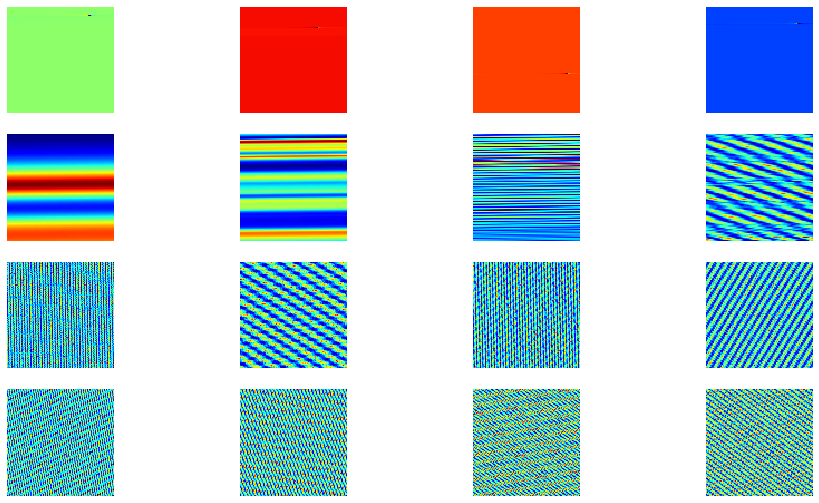

In [16]:
for i in range(16):
    plt.subplot(4, 4, 1+i)  ## prosím specifikujte přesné rozpětí 
    frequency = np.linspace(1e-8*10**i, 1e-7*10**i, 96**2)/u.day
    power = LombScargle(t=X[m]*u.day,
                               y=robust_scale(y[m].reshape(-1,1))
                                .reshape(len(X[m]),)*u.mag,
                              dy=z[m]*u.mag
                       ).power(frequency)
    plt.imshow(spec2sqr(power))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])